In [862]:
import sys

sys.path.append('/home/jovyan/work')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [525]:
# 3rd party util
import pandas as pd
import numpy as np
import time
from helpers.logger import Logger
from mw.lib import title as mw_t
import matplotlib.pyplot as plt
import swifter

In [707]:
from helpers.load import load_topics, save_to_pickle, load_from_pickle, load_interventions
from helpers.vars import helper_langs, interventions_helper
from helpers.retrieval import load_session
from helpers.diffs_n_diffs import build_windowed_diff_in_diff, replace_outliers_in_series
from helpers.vars import mobility_changepoint_dict, mobility_reverted_dict, changepoints_wiki, changepoints_wiki_mod
from helpers.plot import plot_interventions, plot_all_dashed_dnd, plot_metric_and_did, plot_main_intro_figure

In [4]:
DATA_PATH = '../../../data/coronawiki'

In [5]:
interventions = load_interventions(f'{DATA_PATH}/interventions2.csv')

In [6]:
agg = pd.read_csv(f'{DATA_PATH}/pipeline/results/aggregated.tsv.gz', sep='\t')
agg = agg[agg['date'] < '2020-12-01'] # CHANGE THIS HERE IF MORE DATA!
super_cats = ['Unclassified', 'Culture', 'Geography', 'STEM', 'History and Society']


for cat in super_cats:
    if cat == 'Unclassified':
        continue
    col_start = f'count_ratio:{cat}'
    agg[col_start] = agg[[col for col in agg.columns if col.startswith(col_start)]].sum(axis=1)

agg_dict = {}
codes = agg.code.unique()
for c in codes:
    agg_dict[c] = agg[agg.code==c].copy()
    agg_dict[c]['date'] = agg_dict[c]['date'].apply(lambda d: pd.to_datetime(d, format='%Y-%m-%d'))
    agg_dict[c] = agg_dict[c].set_index('date')

In [7]:
agg

,date,covid,user_kind,index,count,rev_len_sum,entropy,count:Culture.Biography.Biography*,rev_len_sum:Culture.Biography.Biography*,count_ratio:Culture.Biography.Biography*,...,actor_user,edit_1,edit_5,revision_is_identity_reverted,revision_is_identity_revert,code,count_ratio:Culture,count_ratio:Geography,count_ratio:STEM,count_ratio:History and Society
0,2018-01-01,False,account,69415429,16982,317421983.0,8.978807,4132.0,83900765.0,1116.619968,...,232.0,131.0,32.0,400,742,de,4996.473235,4867.595318,2388.854023,1172.077424
1,2018-01-01,False,anonymous,8191385,1979,44773852.0,6.771333,559.0,12193444.0,159.859571,...,0.0,0.0,0.0,580,89,de,875.450153,604.529779,354.022971,181.997097
2,2018-01-01,False,bot,1540257,267,10845764.0,5.463911,20.0,764138.0,6.216667,...,0.0,0.0,0.0,12,6,de,23.966667,14.583333,5.733333,23.716667
3,2018-01-02,False,account,254740364,20220,365770292.0,9.117339,4591.0,102386561.0,1219.702581,...,359.0,214.0,52.0,704,1108,de,5837.012500,6007.235768,2797.906993,1297.844739
4,2018-01-02,False,anonymous,37378321,2526,55281252.0,7.338263,680.0,15983991.0,177.513672,...,0.0,0.0,0.0,652,128,de,1100.878655,774.115299,497.580908,209.425139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45911,2020-11-30,False,anonymous,1063231017731,24585,831200226.0,9.283645,8394.0,254415990.0,2454.817960,...,0.0,0.0,0.0,6180,897,en,13469.630264,8315.394988,3875.841160,2563.133587
45912,2020-11-30,False,bot,1541037007043,21407,694513103.0,9.946919,6487.0,224649323.0,1877.109385,...,0.0,0.0,0.0,110,979,en,11756.219711,6864.569156,4640.818902,2715.392231
45913,2020-11-30,True,account,10319398066,386,61737269.0,10.422103,13.0,2591178.0,3.333333,...,4535.0,1852.0,586.0,3523,7601,en,96.400000,995.750000,473.266667,124.583333
45914,2020-11-30,True,anonymous,2195595463,97,14789733.0,9.283645,0.0,0.0,0.000000,...,0.0,0.0,0.0,6180,897,en,0.000000,112.166667,89.500000,11.333333


## Visualization

en: Processing...


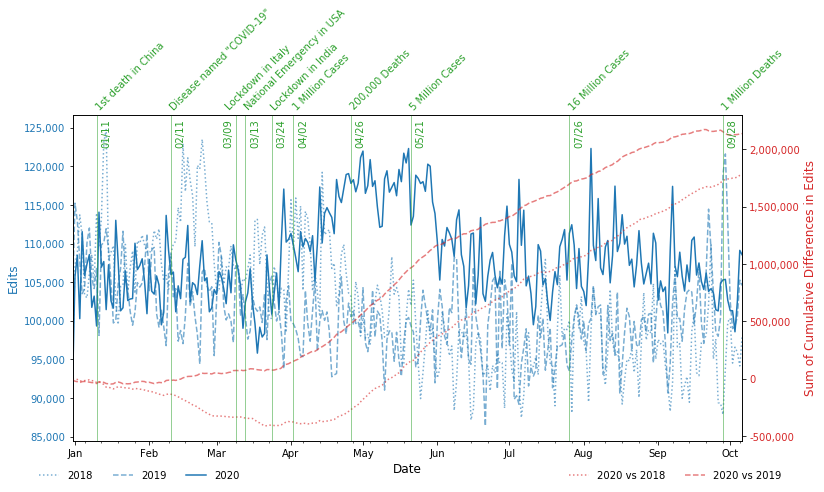

In [702]:
fig_main = plot_main_intro_figure(agg, 'en', window=1, date_pos_top=True, figsize=(12,6))
fig_main.savefig('../../imgFinal/intro_fig.pdf', bbox_inches='tight')

en: Processing...


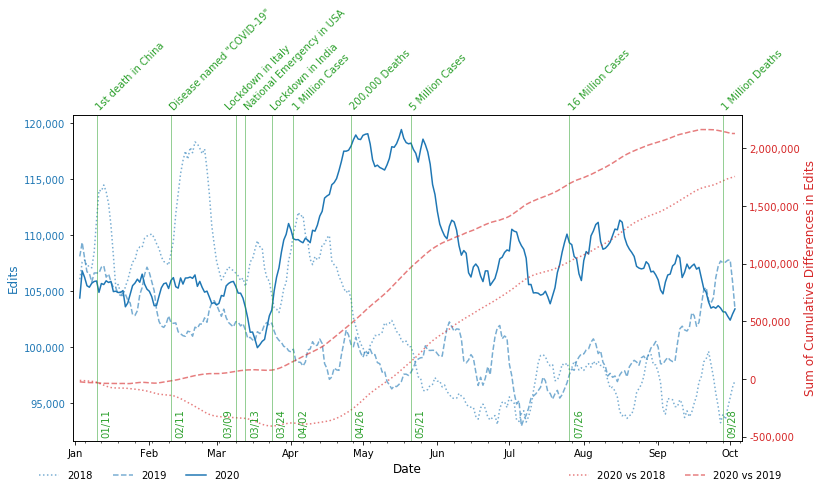

In [698]:
fig_main = plot_main_intro_figure(agg, 'en', window=7, date_pos_top=False, figsize=(12,6))
fig_main.savefig('../../imgFinal/intro_fig_win7.pdf', bbox_inches='tight')

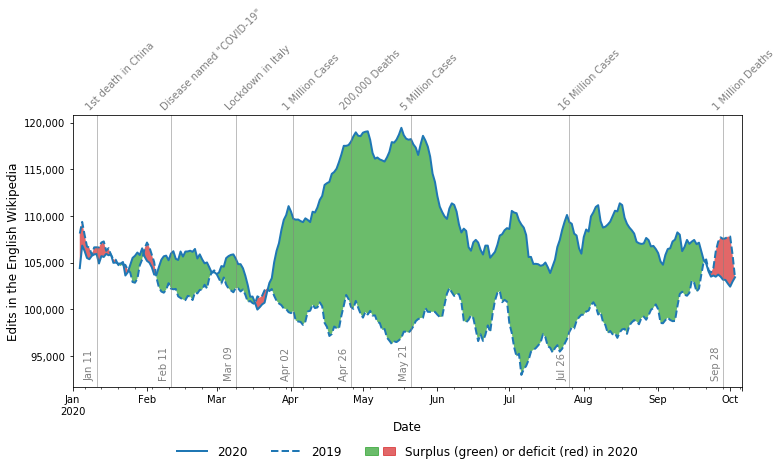

In [920]:
fig_main = plot_main_intro_figure(agg, 'en')
fig_main.savefig('../../imgFinal/intro_fig_final.pdf', bbox_inches='tight')

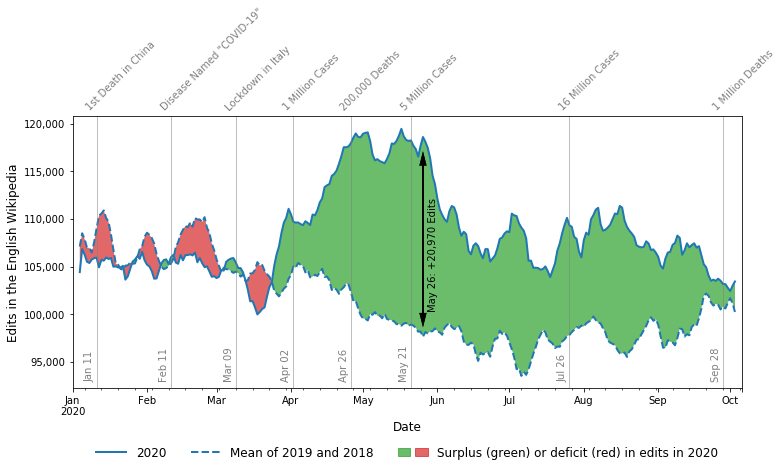

In [1275]:
fig_main= plot_main_intro_figure(agg, 'en', years_merge=True)
fig_main.savefig('../../imgFinal/intro_fig_final_avg.pdf', bbox_inches='tight')

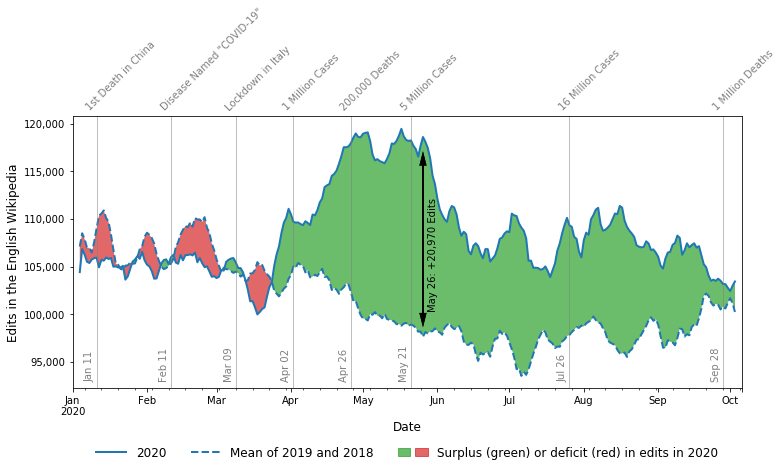

In [1266]:
fig_main= plot_main_intro_figure(agg, 'en', years_merge=True)
fig_main.savefig('../../imgFinal/intro_fig_final_avg.pdf', bbox_inches='tight')

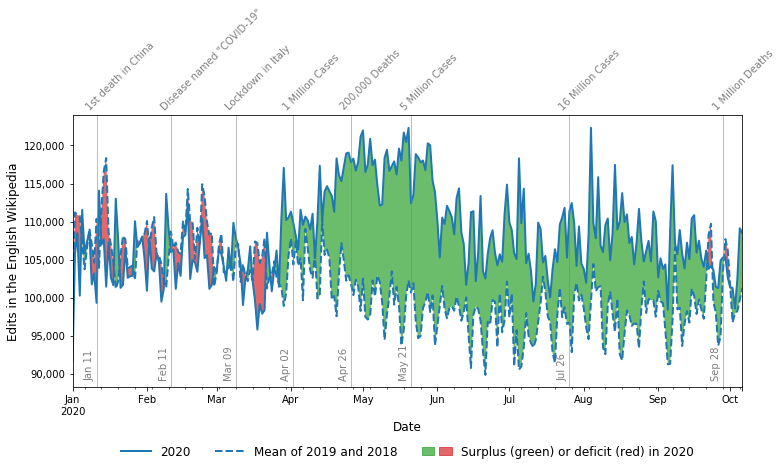

In [924]:
fig_main= plot_main_intro_figure(agg, 'en', years_merge=True, window=1)
fig_main.savefig('../../imgFinal/intro_fig_final_avg_win1.pdf', bbox_inches='tight')

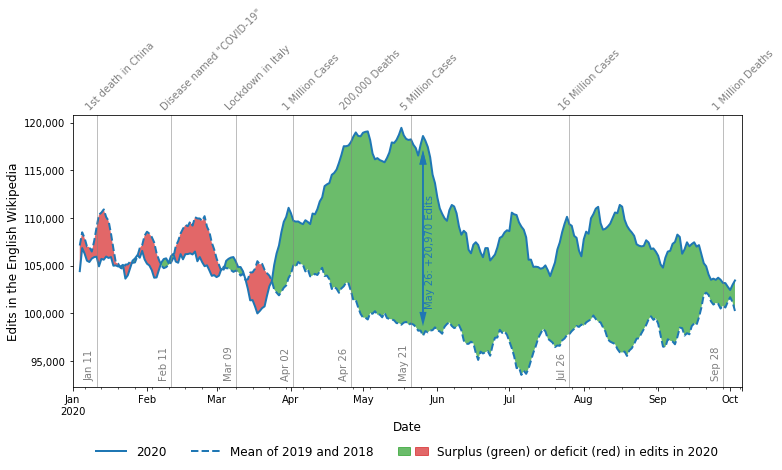

In [1236]:
col='count'
user_kinds=('account', 'anonymous')
years_merge=True
from_date='2020-01-01'
to_date='2020-10-07'
include_covid=None
window=7
figsize=(12, 5)
ylabel='Edits in the English Wikipedia'
xlabel='Date'

user_kinds = list(user_kinds)
# calc csum
n_days = (datetime.datetime.strptime(to_date, "%Y-%m-%d") - datetime.datetime.strptime(from_date, "%Y-%m-%d")).days

# extract and aggregate data
df_code = agg[agg.code == code][['date', col, 'covid', 'user_kind']]
df_code = pd.concat([df_code[(pd.to_datetime(df_code.date) >= pd.to_datetime(f'{year}-01-01')) & (
        pd.to_datetime(df_code.date) < (pd.to_datetime(f'{year}-01-01') + relativedelta(days=n_days)))] for
                     year in ([2019, 2020] if not years_merge else [2018, 2019, 2020])])
df_code = df_code if not include_covid else df_code[df_code.covid == include_covid]
df_code = df_code[df_code.user_kind.isin(user_kinds)].groupby(['date'])['count'].sum().reset_index()
df_code['date'] = pd.to_datetime(df_code.date)
df_code['year'] = pd.to_datetime(df_code.date).dt.year
df_code['day'] = pd.to_datetime(df_code.date).dt.dayofyear

# combine 2018 and 2019
if years_merge:
    merged = df_code[df_code.year < 2020].groupby('day')['count'].mean()
    df_code = df_code[df_code.year >= 2019].copy()
    df_code.loc[df_code.year == 2019, 'count'] = merged.values

# build plot dataframe by pivoting
styles = ['--', '-']
df_pvt = df_code.pivot(index='day', columns='year')

# now, take care of windowing
df_pvt_years = df_pvt[df_pvt.columns[:2]]
df_pvt = df_pvt.rolling(window=window, center=True).mean()
df_pvt = pd.concat([df_pvt_years, df_pvt], axis=1)
df_pvt['diff'] = df_pvt[('count', 2020)] - df_pvt[('count', 2019)]

# === PLOTTING
# plots figure for english edits and csum of edits
fig, ax1 = plt.subplots(figsize=figsize)
c_l, c_fill_neg, c_fill_pos, c_events = 'tab:blue', 'tab:red', 'tab:green', 'tab:gray'

ax1.xaxis.set_major_locator(mdates.WeekdayLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

df_pvt.plot(x=('date', 2020), y=col, color=c_l, lw=2, style=styles, ax=ax1)

x, y1, y2, alpha_fill = df_pvt[('date', 2020)].values, df_pvt[('count', 2019)], df_pvt[('count', 2020)], 0.7
ax1.fill_between(x, y2, y1, where=y1 >= y2, facecolor=c_fill_neg, interpolate=True, alpha=alpha_fill)
ax1.fill_between(x, y2, y1, where=y1 < y2, facecolor=c_fill_pos, interpolate=True, alpha=alpha_fill)

ax1.set_xlabel(xlabel, fontsize='large')
ax1.set_ylabel(ylabel, fontsize='large')
format_labels_thousand_comma(ax1)

# add legend info
lines = [Line2D([], [], color=c_l, lw=2, ls=styles[1]), Line2D([], [], color=c_l, lw=2, ls=styles[0])]
fill_pos, fill_neg = Patch(facecolor=c_fill_pos, edgecolor=c_fill_pos, lw=1, alpha=alpha_fill), \
                     Patch(facecolor=c_fill_neg, edgecolor=c_fill_neg, lw=1, alpha=alpha_fill)

label_2019 = '2019' if not years_merge else 'Mean of 2019 and 2018'
ax1.legend(handles=lines + [(fill_pos, fill_neg,)],
           labels=['2020', label_2019, 'Surplus (green) or deficit (red) in edits in 2020'],
           loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3,
           fancybox=False, shadow=False, frameon=False, edgecolor=None, handlelength=2.5,
           handler_map={tuple: HandlerTuple(ndivide=None)}, fontsize='large')

# plot events
trans = transforms.blended_transform_factory(ax1.transData, ax1.transAxes)

# for now, very static.
for changepoint, date in changepoints_wiki_mod.items():
    day = pd.to_datetime(date)
    coordinates = day - relativedelta(days=5)
    ax1.axvline(day, alpha=0.5, color=c_events, lw=1)
    ax1.text(coordinates, 0.025, day.strftime('%b %d'), color=c_events, rotation=90, va='bottom', transform=trans)
    ax1.text(coordinates, 1.015, changepoint, color=c_events, rotation=45, va='bottom', ha='left', transform=trans)

# === Arrows
c_arrow = 'tab:blue' #c_events
max_day = df_pvt.loc[df_pvt['diff'].idxmax()]
max_date = max_day['date', 2020]
from_val, to_val = max_day['count', 2019], max_day['count', 2020]
ax1.text(max_date + relativedelta(days=1), 0.29,
         f"{max_date.strftime('%b %d')}: +{round(max_day['diff'].values[0]):,} Edits", color=c_arrow, rotation=90,
         va='bottom', transform=trans)
arr = plt.arrow(max_date, from_val + 2000, 0, to_val - from_val - 3500, width=0.5,
                length_includes_head=True, head_length=1500, head_width=3, linewidth=0, shape='full',
                color=c_arrow)
arr2 = plt.arrow(max_date, to_val - 2500, 0, from_val - to_val + 3500, width=0.5,
                 length_includes_head=True, head_length=1500, head_width=3, linewidth=0, shape='full',
                 color=c_arrow)
ax1.add_patch(arr)
#ax1.add_patch(arr2)
fig.savefig('test.pdf')

In [1196]:
df_pvt.nlargest(3, 'diff')

date                    count                         diff
year       2019       2020          2019           2020              
day                                                                  
147  2019-05-27 2020-05-26  97626.071429  118596.000000  20969.928571
138  2019-05-18 2020-05-17  98784.642857  119454.000000  20669.357143
148  2019-05-28 2020-05-27  98116.357143  118099.428571  19983.071429

In [1207]:
df_pvt.loc[df_pvt['diff'].idxmax()]

       year
date   2019    2019-05-27 00:00:00
       2020    2020-05-26 00:00:00
count  2019                97626.1
       2020                 118596
diff                       20969.9
Name: 147, dtype: object

146